In [23]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
import pickle
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Flatten, Reshape, concatenate, Dropout
from keras.optimizers import Adam
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [24]:
# load descriptions
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "dataset/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [25]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Total Loaded: {}'.format(len(descriptions)))

Total Loaded: 8092


In [26]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [27]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [28]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [29]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc


vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: {}'.format(len(vocabulary)))

Original Vocabulary Size: 8763


In [30]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [31]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset 
filename = 'dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Total Training Dataset: {}'.format(len(train)))

Total Training Dataset: 6000


In [32]:
# Below path contains all the images
images = 'dataset/Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [33]:
# Create a list of all the training images with their full path names
train_images_file = 'dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images:
        train_img.append(i) 


In [34]:
# Create a list of all the testing images with their full path names
test_images_file = 'dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images:
        test_img.append(i) 

In [35]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: Train : {}'.format(len(train_descriptions)))


Descriptions: Train : 6000


In [36]:
#preprocessing the images
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [37]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [38]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [39]:
# Encoding a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
# Encoding all the train images 
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck train features to disk
with open("encoded_files/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck test features to disk
with open("encoded_files/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [42]:
train_features = load(open("encoded_files/encoded_train_images.pkl", "rb"))
print('Photos: Training: {}'.format(len(train_features)))

Photos: Training: 6000


In [43]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [45]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))

Preprocessed words 7578 -> 1651


In [46]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [47]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [48]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length1 = max_length(train_descriptions)
print('Maximum Description Length: {}'.format(max_length1))

Maximum Description Length: 34


In [49]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [50]:
# Load Glove vectors
glove_dir = 'glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400001 word vectors.


In [51]:
embedding_dim = 200

# Get 200-dim dense vector for each of the words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [53]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length1,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [55]:
model.layers[2]

In [56]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [57]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [58]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [43]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length1, number_pics_per_batch)
history = model.fit_generator(generator, epochs=20,  steps_per_epoch=steps, verbose=1)
model.save('saved_model/model_' + str(20) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
2000/2000 [==============================] - 538s 269ms/step - loss: 4.1238
Epoch 2/20
2000/2000 [==============================] - 508s 254ms/step - loss: 3.4282
Epoch 3/20
2000/2000 [==============================] - 509s 254ms/step - loss: 3.2085
Epoch 4/20
2000/2000 [==============================] - 486s 243ms/step - loss: 3.0762
Epoch 5/20
2000/2000 [==============================] - 487s 244ms/step - loss: 2.9795
Epoch 6/20
2000/2000 [==============================] - 486s 243ms/step - loss: 2.9073
Epoch 7/20
2000/2000 [==============================] - 492s 246ms/step - loss: 2.8496
Epoch 8/20
2000/2000 [==============================] - 493s 246ms/step - loss: 2.8014
Epoch 9/20
2000/2000 [==============================] - 493s 246ms/step - loss: 2.7620
Epoch 10/20
2000/2000 [==============================] - 493s 247ms/step - loss: 2.7302
Epoch 11/20
2000/2000 [==============================] - 493s 246ms/step - loss: 

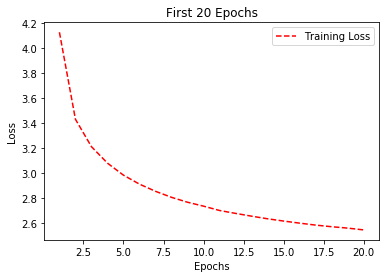

In [61]:
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.figure()  
    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('First 20 Epochs')

In [48]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [58]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length1, number_pics_per_batch)
history1 = model.fit_generator(generator, epochs=10, steps_per_epoch=steps, verbose=1)
model.save('saved_model/model_' + str(30) + '.h5')

Epoch 1/10
1000/1000 [==============================] - 493s 493ms/step - loss: 2.5115
Epoch 2/10
1000/1000 [==============================] - 490s 490ms/step - loss: 2.4866
Epoch 3/10
1000/1000 [==============================] - 520s 520ms/step - loss: 2.4683
Epoch 4/10
1000/1000 [==============================] - 531s 531ms/step - loss: 2.4551
Epoch 5/10
1000/1000 [==============================] - 538s 538ms/step - loss: 2.4447
Epoch 6/10
1000/1000 [==============================] - 484s 484ms/step - loss: 2.4312
Epoch 7/10
1000/1000 [==============================] - 500s 500ms/step - loss: 2.4245
Epoch 8/10
1000/1000 [==============================] - 472s 472ms/step - loss: 2.4153
Epoch 9/10
1000/1000 [==============================] - 489s 489ms/step - loss: 2.4072
Epoch 10/10
1000/1000 [==============================] - 491s 491ms/step - loss: 2.3975


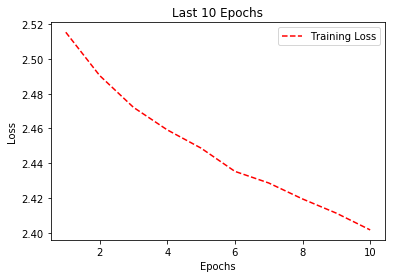

In [62]:
training_loss = history1.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.figure()  
    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Last 10 Epochs')

In [60]:
model.load_weights('saved_model/model_30.h5')

In [61]:
images = 'dataset/Flickr8k_Dataset/Flicker8k_Dataset/'

In [63]:
with open("encoded_files/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [64]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length1):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length1)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

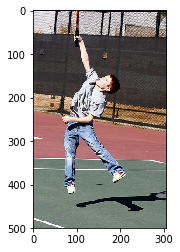

Greedy: man in white shirt bouncing baseball


In [65]:
z=1
pic = list(encoding_test.keys())[999]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))